In [1]:
from source.spinsystem import SpinSystem
from source.utils import read_config_file, reconstruct_grid, visualize_grid, plot_array_list
from datetime import datetime
import numpy as np
from numpy import empty, nan, savetxt

In [ ]:
MAX_FILE_SIZE = 100_000

config_filename = "multising.conf"
config = read_config_file(config_filename)

In [ ]:
# Paramètres
grid_height = int(config["grid_height"])
grid_width  = int(config["grid_width"])
alpha       = float(config["alpha"])
j           = float(config["j"])
total_updates = int(config["total_updates"])
init_up     = float(config["init_up"])
#beta        = float(config["beta"])
T           = float(config["T"])
beta        = 1/T

reduced_alpha              = -2 * beta * alpha
reduced_neighbour_coupling = -2 * beta * j

# On stocke la magnétisation
magnetisation = empty((min(total_updates, MAX_FILE_SIZE), ), dtype=float)
magnetisation[:] = nan

# Instancie le système
spin_system = SpinSystem(
    grid_height=grid_height,
    grid_width=grid_width,
    init_up=init_up
)

full_grids = []
full_grids.append(reconstruct_grid(spin_system.black, spin_system.white))

In [ ]:
for ii in range(total_updates):
    # Mise à jour
    mag = spin_system.update(reduced_neighbour_coupling, reduced_alpha)
    full_grids.append(reconstruct_grid(spin_system.black, spin_system.white))
    magnetisation[ii % MAX_FILE_SIZE] = mag

    # Sauvegarde tous les MAX_FILE_SIZE
    if ii > 0 and (ii % MAX_FILE_SIZE == 0):
        savetxt(f"magnetisation_{ii}.dat", magnetisation)
        magnetisation[:] = nan

# Sauvegarde finale
savetxt(f"magnetisation_{ii}.dat", magnetisation)

In [110]:
plot_array_list(full_grids, max_cols=20)

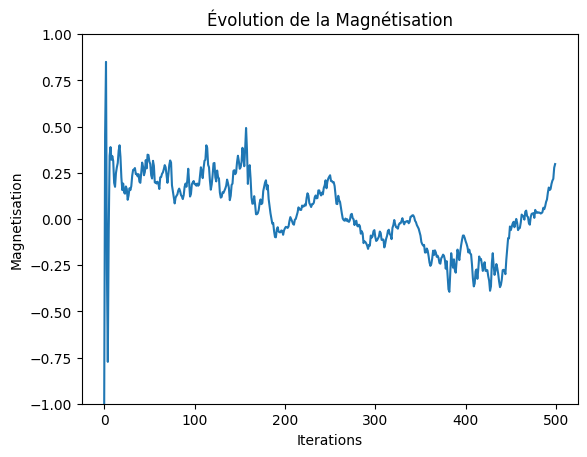

In [101]:
import matplotlib.pyplot as plt
plt.plot(magnetisation)
plt.xlabel("Iterations")
plt.ylabel("Magnetisation")
plt.ylim(-1,1)
plt.title("Évolution de la Magnétisation")
plt.show()

In [ ]:
price = np.log(np.abs(magnetisation[1:])) - np.log(np.abs(magnetisation[:total_updates-1]))
plt.plot(price)

/var/folders/nk/rqbxbzbs6cx3djvmyg89hzhh0000gn/T/ipykernel_21602/826137710.py:1: RuntimeWarning: divide by zero encountered in log
  price = np.log(np.abs(magnetisation[1:])) - np.log(np.abs(magnetisation[:total_updates-1]))
